import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from keras.preprocessing import image
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import shutil
import splitfolders
import time

2023-05-15 13:03:18.446926: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 13:03:18.572889: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 13:03:18.573973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 13:03:19.641034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# !unzip /home/jovyan/dataset2/221.zip -d /home/jovyan/dataset2/

# !rm -r /home/jovyan/dataset2/221

print(tf.__version__)

2.12.0


functions

In [34]:
SAVED_MODEL_BEST_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_ACCURACY_RESULTS2 = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2 = []
EPOCHS = 170 # try different

In [4]:
def get_image_and_transform(path):
    data = utils.load_img(path, color_mode='grayscale', target_size=(64, 64))
    data = utils.img_to_array(data)
    data = np.expand_dims(data, axis=0)
    data = data / 255.0
    return data

In [5]:
def build_dataset(dataset_dir): # build 2 datasets for training and testing
    x_train, y_train = [], []
    classes = sorted(os.listdir(dataset_dir))
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        for image in images:
            full_image_path = os.path.join(class_dir, image)
            if 'ipynb_checkpoints' in full_image_path:
                continue
            x_train.append(get_image_and_transform(full_image_path))
            y_train.append(i)
    return x_train, y_train

In [6]:
def get_examples_and_classes(dataset_dir, num): # return persons' names and persons' ears
    classes = sorted(os.listdir(dataset_dir))
    examples = []
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        examples.append(os.path.join(class_dir, images[num]))

    return classes, examples

In [31]:
def plot(accuracy, loss, val_accuracy, val_loss): # return schedule of accuracy and loss
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')

    ax1.set_ylabel('total loss')
    ax1.plot(loss,color='tab:red')
    ax1.plot( val_loss, color='tab:brown')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('accuracy')  
    ax2.plot( accuracy, color='tab:blue')
    ax2.plot( val_accuracy, color='tab:green')
    ax2.tick_params(axis='y')
    fig.tight_layout()

In [15]:
def plot_many(title='title', data=[]): # return schedules of accuracy
    for i,o in enumerate(data):
        plt.figure(i)
        plt.plot([i for i in range(EPOCHS)],o, label=title)
        plt.legend(loc='upper left')

In [9]:
def max_or_min_avarage_val(list_of_data, accuracy=True): #return dictionary of average values of lists
    dict_all_l = {}
    for i, o in enumerate(list_of_data):
        dict_all_l[i] = sum(o)/len(o)
    if accuracy:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1], reverse=True))
    else:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1]))

In [16]:
def save_lists(): # save lists of accuracy and loss
    t = time.ctime(time.time())[:-5]
    with open(f'accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_ACCURACY_RESULTS:
            f.write("%s\n" % item)
    with open(f'val_accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS:
            f.write("%s\n" % item)

In [11]:
def read_list_from_file(filename): # read accuracy or loss data  from files
    lst = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            if line in ('', ' ','\n'):
                break
            line = line[1:-2].split(', ')
            lst.append([float(i.strip()) for i in line])
    return lst

In [12]:
def show_best_res(list_of_data): # return max value in every list of accuracy
    max_val = {}
    for i, o in enumerate(list_of_data):
        max_val[i] = max(o)
    return dict(sorted(max_val.items(), key=lambda item: item[1], reverse=True))

In [13]:
def create_new_dataset(path):
    images = sorted(os.listdir(path))
    for image in images:
        if 'ipynb_checkpoints' in image:
            continue
        old_path = f'/home/jovyan/dataset2/221/{image}'
        new_path = f"/home/jovyan/dataset2/dataset2/{image[:3]}"

        if os.path.exists(new_path):
            shutil.copyfile(old_path, new_path+'/'+image)
        else:
            os.mkdir(new_path)
            shutil.copyfile(old_path, new_path+'/'+image)

In [38]:
def add_random_noise(image):
    noise = np.random.normal(loc=0, scale=0.0000001, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0., 1.)
    return noisy_image

dataset

In [14]:
train_folder = "/home/jovyan/dataset1/dataset2/train"
test_folder = "/home/jovyan/dataset1/dataset2/test"

In [4]:
# data_folder = "/home/jovyan/dataset2/221"
# create_new_dataset(data_folder)
# train_datagen = "/home/jovyan/dataset2/dataset2"
# splitfolders.ratio(train_datagen, output="/home/jovyan/dataset2", seed=1337, ratio=(.8, 0.1,0.1)) 
train_folder = "/home/jovyan/dataset2/train"
test_folder = "/home/jovyan/dataset2/test"

In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=add_random_noise)#, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (50, 180),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode='grayscale')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (50, 180),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            color_mode='grayscale')



# print(training_set.filepaths)
# print(training_set.classes)
# print(training_set.class_indices)


Found 557 images belonging to 222 classes.
Found 236 images belonging to 222 classes.


model

In [22]:
def model(in_1=32, in_2=32, in_3=32, in_4=64, l2_weight=0.01):
    model = Sequential()
    model.add(Conv2D(filters=in_1,kernel_size=3, strides=1, input_shape=(50,180,1), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=in_2,kernel_size=3, strides=1, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=in_3,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters=in_4,kernel_size=3, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'tanh')) # try delete
    model.add(Dense(units = 222 , activation = 'softmax'))

    model.compile( optimizer='Adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

    return model
summary_example = model()
summary_example.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 50, 180, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 25, 90, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 90, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 45, 32)       0         
 g2D)                                                            
                                                      

choose best hyperparameters

In [8]:
def model_and_best_hyperparameters(nums):
    start_time1 = time.time() 
    for i in nums:
        start_time2 = time.time()
        
        ready_model = model(i,i*2,i*3, i*4)        # change order 
        trained_model = ready_model.fit(training_set, steps_per_epoch = len(training_set), epochs = EPOCHS,
                                        validation_data = test_set, validation_steps=len(test_set))
        
        print("for one training time taken: {:.2f} seconds".format(time.time() - start_time2)) # how much time one training take

        SAVED_MODEL_BEST_ACCURACY_RESULTS.append(trained_model.history['accuracy'])
        SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS.append(trained_model.history['val_accuracy'])
        
    return time.time() - start_time1 # how much time all training take

In [11]:
all_time = model_and_best_hyperparameters([32])

Epoch 1/170


2023-05-15 13:04:24.921061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - ETA: 0s - loss: 5.4216 - accuracy: 0.0521

2023-05-15 13:04:31.694810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 7s 322ms/step - loss: 5.4216 - accuracy: 0.0521 - val_loss: 5.4344 - val_accuracy: 0.0042
Epoch 2/170
18/18 [==============================] - 5s 303ms/step - loss: 3.7109 - accuracy: 0.2316 - val_loss: 6.2339 - val_accuracy: 0.0042
Epoch 3/170
18/18 [==============================] - 5s 302ms/step - loss: 2.2937 - accuracy: 0.5422 - val_loss: 6.6019 - val_accuracy: 0.0042
Epoch 4/170
18/18 [==============================] - 6s 330ms/step - loss: 1.1556 - accuracy: 0.8025 - val_loss: 6.9214 - val_accuracy: 0.0042
Epoch 5/170
18/18 [==============================] - 7s 398ms/step - loss: 0.4176 - accuracy: 0.9408 - val_loss: 7.3444 - val_accuracy: 0.0042
Epoch 6/170
18/18 [==============================] - 6s 335ms/step - loss: 0.1563 - accuracy: 0.9874 - val_loss: 7.7674 - val_accuracy: 0.0042
Epoch 7/170
18/18 [==============================] - 7s 368ms/step - loss: 0.0883 - accuracy: 0.9874 - val_loss: 7.8621 - val_accuracy: 0.0085
Epoch 8/170

In [17]:
print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS))
print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS))
print('all training take {:.2f} minutes'.format(all_time/60))
save_lists()  #val accuracy 0.4634

sorted list of max  epochs' values for accuracy   {0: 1.0}
sorted list of max  epochs' values for val_accuracy   {0: 0.9491525292396545}
all training take 15.99 minutes


In [21]:
# file = 'accuracy Sat May  6 11:19:23.txt'
# l = read_list_from_file(file)
# print("sorted list of max  epochs' values for accuracy  ", show_best_res(l))

train and save model

In [35]:
def final_model():
    ready_model = model(32,64,64,32)
    call_back = ModelCheckpoint(f"/home/jovyan/weights.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    trained_model = ready_model.fit(training_set, steps_per_epoch = len(training_set), epochs = EPOCHS,
                                    validation_data = test_set, validation_steps=len(test_set), callbacks = [call_back])
    
    SAVED_MODEL_BEST_ACCURACY_RESULTS2.append(trained_model.history['accuracy'])
    SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2.append(trained_model.history['val_accuracy'])
    return trained_model, ready_model


In [36]:
history, trained_model = final_model()

Epoch 1/170


2023-05-15 13:53:19.967048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - ETA: 0s - loss: 6.0534 - accuracy: 0.0054

2023-05-15 13:53:25.698957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 6s 294ms/step - loss: 6.0534 - accuracy: 0.0054 - val_loss: 5.4103 - val_accuracy: 0.0042
Epoch 2/170
18/18 [==============================] - 5s 299ms/step - loss: 5.9785 - accuracy: 0.0018 - val_loss: 5.4279 - val_accuracy: 0.0042
Epoch 3/170
18/18 [==============================] - 5s 289ms/step - loss: 5.7982 - accuracy: 0.0018 - val_loss: 5.4588 - val_accuracy: 0.0042
Epoch 4/170
18/18 [==============================] - 5s 257ms/step - loss: 5.7508 - accuracy: 0.0054 - val_loss: 5.4910 - val_accuracy: 0.0042
Epoch 5/170
18/18 [==============================] - 5s 258ms/step - loss: 5.7101 - accuracy: 0.0036 - val_loss: 5.5252 - val_accuracy: 0.0042
Epoch 6/170
18/18 [==============================] - 5s 254ms/step - loss: 5.7014 - accuracy: 0.0018 - val_loss: 5.5476 - val_accuracy: 0.0042
Epoch 7/170
18/18 [==============================] - 5s 258ms/step - loss: 5.7049 - accuracy: 0.0036 - val_loss: 5.5848 - val_accuracy: 0.0042
Epoch 8/170

plot model

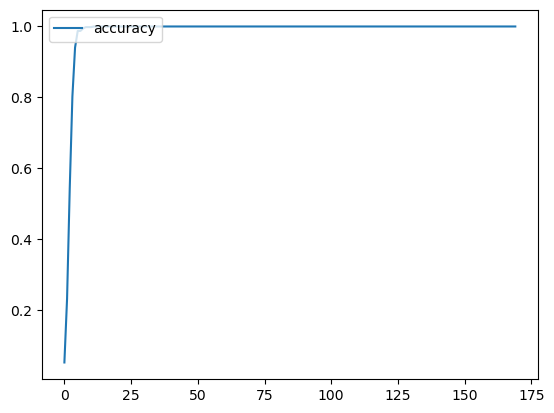

In [18]:
# plot_many('accuracy', SAVED_MODEL_BEST_ACCURACY_RESULTS)

sorted list of max  epochs' values for accuracy   {0: 0.04847396910190582}
sorted list of max  epochs' values for val_accuracy   {0: 0.012711863964796066}


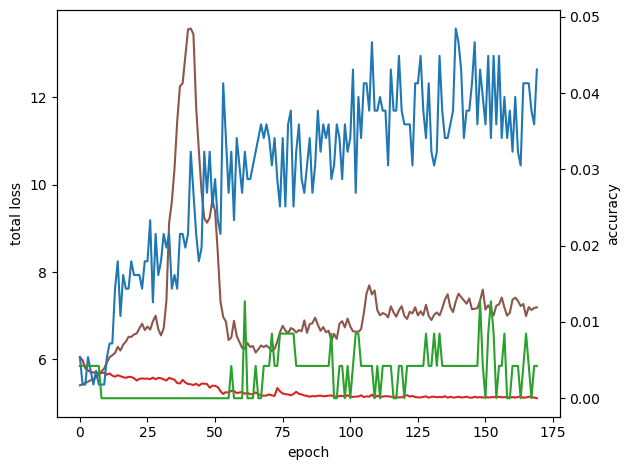

In [37]:
if trained_model:
    print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS2))
    print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2))
    plot(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])
    # save_lists()

predict

In [26]:
predict_model = Sequential()
for layer in trained_model.layers[:-1]:
    predict_model.add(layer)
predict_model.add(Dense(units=1, activation=None))
predict_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
predict_model.summary()


predict_model.load_weights('weights.hdf5', skip_mismatch=True, by_name=True)

# # Load weights and biases from model manually
# for i in range(len(predict_model.layers) - 1):
#     predict_model.layers[i].set_weights(model.layers[i].get_weights())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 50, 180, 32)       320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 25, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 45, 64)       0         
 2D)                                                             
                                                      

In [27]:
def distance_metric(x1, x2):
    return tf.sqrt(tf.reduce_sum(tf.square(x1 - x2), axis=1))

def predict(model, known_data_path, unknown_data_path):
    known_data = get_image_and_transform(known_data_path)
    unknown_data = get_image_and_transform(unknown_data_path)

    known_data = model.predict(known_data)
    unknown_data = model.predict(unknown_data)
    distance = distance_metric(unknown_data, known_data)

    threshold = 0.018614814   # try logistic regression or support vector machine
    return  distance < threshold, distance

predict(predict_model, '/home/jovyan/12.jpg', '/home/jovyan/22.jpg')

ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 50, 180, 1), found shape=(None, 64, 64, 1)


plot prediction

In [ ]:
classes, examples1 = get_examples_and_classes(test_folder,1)
classes, examples2 = get_examples_and_classes(test_folder,2)
y_true = [i for i in range(len(classes))]
y_predict_tensors = []
y_predict_labels = []

for i in range(len(classes)):  # try build histogram
    predict_label, predict_tensor = predict(predict_model, examples1[i], examples2[i])
    y_predict_tensors.append(predict_tensor)
    y_predict_labels.append(predict_label)    

In [ ]:
print(classification_report(y_true, y_predict_labels, target_names=classes))

choose best threshold

In [ ]:
thresholds = np.linspace(0.0001, 0.5, 1000)

# Calculate F1 score for each threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_predict_tensors < threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred, average='micro'))

# Choose the threshold that maximizes F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold